contour_list:[0, 10, 20, 30, 50, 100]
Clipping extents: XMin: 441199.0, XMax: 450611.0, YMin: 6774690.8, YMax: 6781929.2
Clipping source soundings to the specified extents...
Saving clipped source soundings to: ./output/Bathymetric_Features/source_soundings_clipped.gpkg


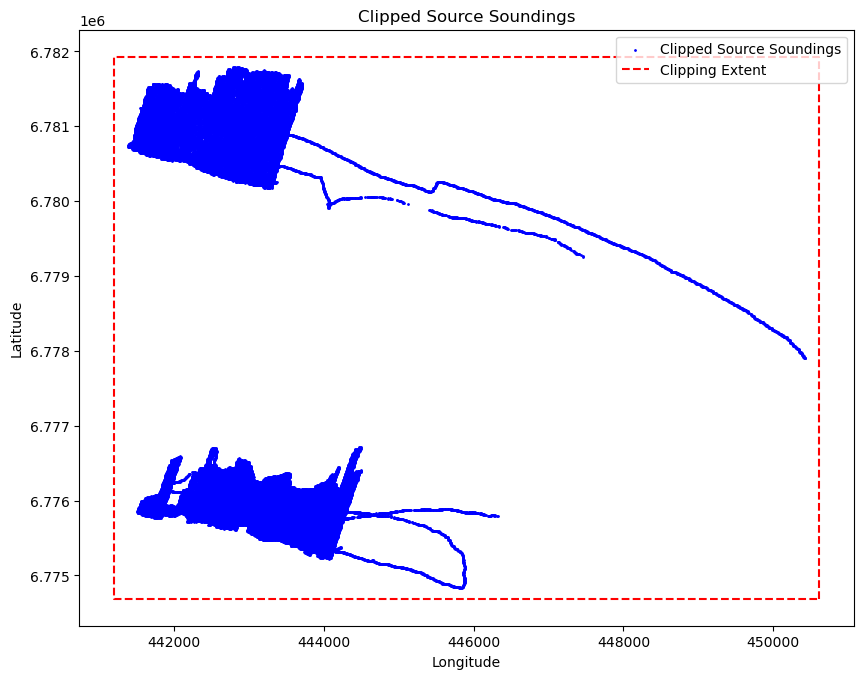

Clipping completed successfully.


In [32]:
# Clipping Bathymetric Survey Layer to Bounding Box Script
#
# This script clips bathymetric survey point data to a specified bounding box derived from a perimeter geometry.
# The clipped data is saved to a GeoPackage for further analysis and visualization.
#
# Inputs:
#   - input_survey_layer: Path to the GeoPackage containing bathymetric survey points.
#   - perimeter_gdf: GeoPackage containing the bounding box geometry.
#
# Outputs:
#   - output_survey_layer_clip: GeoPackage with bathymetric survey points clipped to the bounding box.
#   - A plot visualizing the clipped survey points and the clipping extent.
#
# Method:
#   - survey_layer_clip()
#
# Reference:
#   - https://github.com/umap-iic/UMap/blob/310d08604aeba3592c50e85dd5eb80ae218459cd/UMap.py#L2664

import geopandas as gpd
import rasterio
from shapely.geometry import box, Point
import os
import matplotlib.pyplot as plt

import json

# Define the JSON file path
PARAMS_FILE = "./input/user_parameters.json"

def load_parameters():
    """Loads parameters from the JSON file."""
    if os.path.exists(PARAMS_FILE):
        with open(PARAMS_FILE, "r") as f:
            return json.load(f)
    return {}

# Retrieve user-defined parameters
params = load_parameters()
contour_list = params['contour_list']
print(f'contour_list:{contour_list}')
output_bathymetry_folder = './output/Bathymetric_Features/'

if params['augment_bathymetry']:
    input_bathymetry_path = os.path.join(output_bathymetry_folder, 'merged_bathymetry_10_100_gebco.tif')
else:
    input_bathymetry_path = os.path.join(output_bathymetry_folder, 'reprojected_bathymetry.tif')

# Input variables
bathymetry_basename = os.path.basename(input_bathymetry_path).split('.')[0]
bathymetry_file_type = '.' + os.path.basename(input_bathymetry_path).split('.')[1]
bathymetry_current_dir = os.path.dirname(input_bathymetry_path)
output_chart_folder = params['output_chart_dir']

# Convert input bathymetry to points
if os.path.exists(os.path.join(bathymetry_current_dir, bathymetry_basename + '_projected' + bathymetry_file_type)):
    input_bathymetry_path = os.path.join(bathymetry_current_dir, bathymetry_basename + '_projected' + bathymetry_file_type)

with rasterio.open(input_bathymetry_path) as src:
    raster_data = src.read(1) # assumes single band
    
    # Mask to ignore no-data values
    nodata_value = src.nodata
    transform = src.transform

    # Store data
    points, depths = list(), list()
    
    for row in range(raster_data.shape[0]):
        for col in range(raster_data.shape[1]):
            value = raster_data[row, col]
            if nodata_value is not None and value == nodata_value:
                continue  # Skip no-data values
            
            # Convert raster row/col to coordinates
            x, y = rasterio.transform.xy(transform, row, col, offset="center")
            points.append(Point(x, y))
            depths.append(value)

soundings_gdf = geopandas.GeoDataFrame({"SOUNDG": depths}, geometry=points, crs=src.crs)
output_file = os.path.join(output_bathymetry_folder, 'source_soundings.gpkg')
if os.path.exists(output_file):
    os.remove(output_file)
soundings_gdf.to_file(output_file, driver="GPKG")

# Load the perimeter (bounding box) from chartlimit_utm.geojson
perimeter_gdf = geopandas.read_file('./output/Chart_Features/chartlimit_utm.geojson')

# Extract the perimeter geometry (assuming there's only one geometry)
perimeter = perimeter_gdf.geometry[0]

# Identify perimeter bounds
minx, miny, maxx, maxy = perimeter.bounds

# Assign the extents for clipping
extents = (minx, miny, maxx, maxy)

# Step 1: Check if the GeoDataFrame is empty
if soundings_gdf.empty:
    print("Error: The input survey layer is empty.")
else:
    # Step 2: Create a bounding box polygon from the extents
    xmin, ymin, xmax, ymax = extents
    print(f"Clipping extents: XMin: {xmin}, XMax: {xmax}, YMin: {ymin}, YMax: {ymax}")
    bbox = box(xmin, ymin, xmax, ymax)
    bbox_gdf = geopandas.GeoDataFrame({'geometry': [bbox]}, crs=soundings_gdf.crs)

    # Step 3: Clip the survey layer to the bounding box
    print("Clipping source soundings to the specified extents...")
    clipped_gdf = geopandas.clip(soundings_gdf, bbox_gdf)

    # Step 4: Save the clipped data to the output file
    print(f"Saving clipped source soundings to: {os.path.join(output_bathymetry_folder,'source_soundings_clipped.gpkg')}")
    output_file = os.path.join(output_bathymetry_folder, 'source_soundings_clipped.gpkg')
    if os.path.exists(output_file):
        os.remove(output_file)
    clipped_gdf.to_file(output_file, driver='GPKG')


    # Optional: Visualize the clipped survey layer
    fig, ax = plt.subplots(figsize=(10, 10))
    clipped_gdf.plot(ax=ax, markersize=1, color='blue', label='Clipped Source Soundings')
    bbox_gdf.boundary.plot(ax=ax, edgecolor='red', linestyle='--', label='Clipping Extent')
    ax.set_title("Clipped Source Soundings")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    plt.show()

    print("Clipping completed successfully.")


Reading Bathymetric Extent File: 2025-04-17 09:27:25.687868
Reading Bathymetric Extent File completed in 0.018399 seconds
Reading Source Soundings File: 2025-04-17 09:27:25.706358
Input Sounding Count: 36610
Reading Source Soundings File completed in 1.148685 seconds
Filtering Source Soundings: 2025-04-17 09:27:26.855105
Filtering Source Soundings completed in 1.552655 seconds
Filtered Sounding Count: 36565
Reading Shoreline File: 2025-04-17 09:27:28.407941
Reading Shoreline completed in 0.118128 seconds
Retrieving Boundary Information for Triangulation: 2025-04-17 09:27:28.526124
Retrieving Boundary Information completed in 0.084155 seconds
Performing Triangulation: 2025-04-17 09:27:28.610338
projected_source_soundings=36565
Start read_xyz_list_to_pointset
Start triangulation
original_idx_list[0:5]: [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5]]
Type of first element: <class 'list'>
Type of boundary_segment_vertices: <class 'list'>
Length of boundary_segment_vertices: 1570
Type of original_

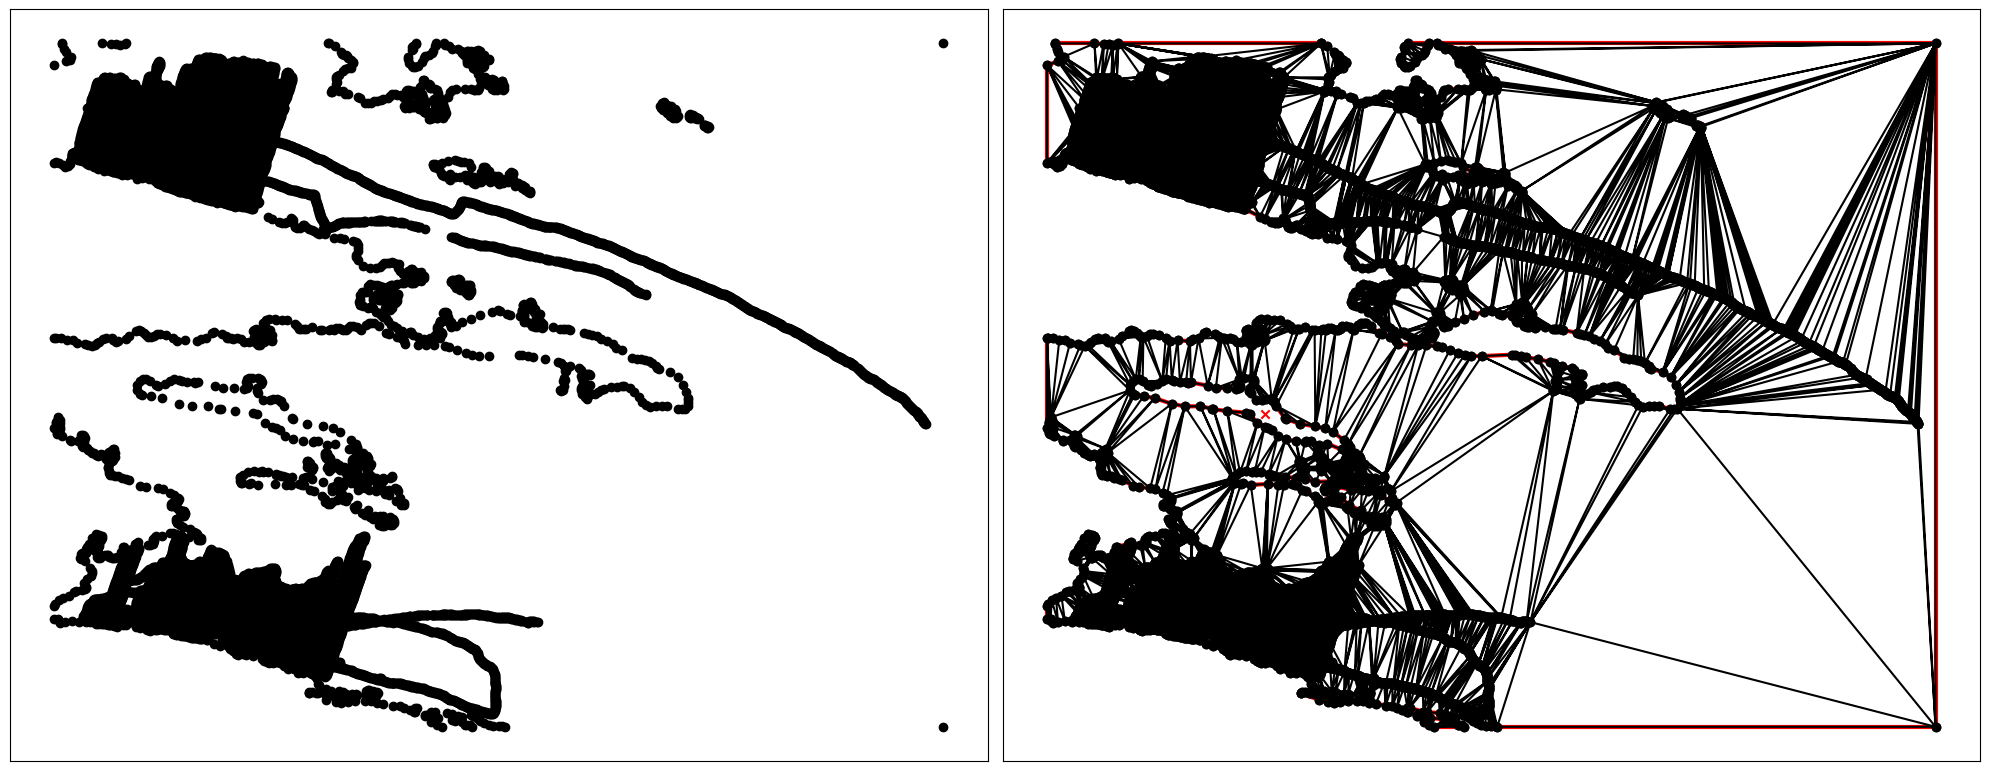

Plotting Triangulation completed in 1.245397 seconds


In [33]:
# This cell performs the following tasks:
#     Filter soundings on land by depth (negative/positive values) and spatially (intersect with land features)
#     Gathers information for constrained triangulation
#     Triangulates
#     Visualize triangulation

import geopandas as gpd
import triangle
import datetime
import json
import matplotlib.pyplot as plt
from shapely.geometry import mapping, Polygon, Point ### NEW CODE
from shapely.ops import unary_union, linemerge
import os
import numpy as np

# Triangulation tools in utilities
import sys
sys.path.insert(1, r'./lib')
from utilities import *
from reader import Reader
# --------------------------- Configuration --------------------------- #

# Parametrs
input_layer_path = r'./output/Bathymetric_Features/source_soundings_clipped.gpkg'
bathymetric_extent_path = r'./output/Bathymetric_Features/Bathymetric_Extent.geojson'
shoreline_path = './output/Land_Features/shoreline_clip_with_chartlimit_utm.geojson'
tin_dict_path = r'./output/Bathymetric_Features/TIN.txt'
land_points_output_path = './output/Land_Features/land_points.gpkg'
final_source_soundings_output_path = r'./output/Bathymetric_Features/source_soundings_final.gpkg'
output_bathymetry_dir = r'./output/Bathymetric_Features/'

# Depth direction, positive or negative down. This allows us to filter out intertidal and land soundings.
# This needs to be an input parameter from the user.
depth_direction = 'NEGATIVE_DOWN'

# if depth_direction == 'NEGATIVE_DOWN':
#     input_depth_direction = True
# elif depth_direction == 'POSITIVE_DOWN':
#     input_depth_direction = False

# Read bathymetric extent
# This extent is used to constrain the triangulation to the "water" area and to eliminate polygons over land
# when depth area polygons are being created. 
# Start timing
start_time = datetime.datetime.now()
print(f"Reading Bathymetric Extent File: {start_time}")

projected_bathymetric_extent_gdf = gpd.read_file(bathymetric_extent_path)
projected_bathymetric_extent = unary_union(projected_bathymetric_extent_gdf.geometry)

# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Reading Bathymetric Extent File completed in {elapsed_time.total_seconds()} seconds")

# Get coordinate system information to remain in projected coordinate system (meters)
projected_coord_system = projected_bathymetric_extent_gdf.crs

# Read input soundings
# Reads the input soundings, which were derived in a previous step (source_soundings_clipped.gpkg), where
# the source soundings are clipped to the chart extent
# Start timing
start_time = datetime.datetime.now()
print(f"Reading Source Soundings File: {start_time}")

# Read source data
projected_source_all_data_frame = gpd.read_file(input_layer_path)
print(f"Input Sounding Count: {len(projected_source_all_data_frame.geometry)}")

# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Reading Source Soundings File completed in {elapsed_time.total_seconds()} seconds")

# Filter soundings
# This step removes all soundings that are on land, which can occur from differences in the collection period
# from the shoreline and bathymetry. If soundings are outside the bathymetric extent, it will crash the 
# constrained triangulation used for contouring
# Start timing
start_time = datetime.datetime.now()
print(f"Filtering Source Soundings: {start_time}")

# Clip source soundings to bathymetric extent
projected_source_soundings_gdf = gpd.clip(projected_source_all_data_frame, projected_bathymetric_extent_gdf)
if os.path.exists(final_source_soundings_output_path):
    os.remove(final_source_soundings_output_path)
projected_source_soundings_gdf.to_file(final_source_soundings_output_path, driver="GPKG")

# Creates a list of x,y,z values from the soundings clipped to the bathymetric extent. This list is passed to a reader function
# that creates a pointset object from the list, which converts the x,y,z values to a Vertex object and filters out land values
depth_field = r'SOUNDG'
projected_source_soundings = [[point.x, point.y, depth] for point, depth in zip(projected_source_soundings_gdf.geometry, projected_source_soundings_gdf[depth_field])]

# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Filtering Source Soundings completed in {elapsed_time.total_seconds()} seconds")
print(f"Filtered Sounding Count: {len(projected_source_soundings_gdf.geometry)}")

# Read shore line
# Shoreline is used to attibute corresponding vertices of the bathymetric extent with a depth of 0
# Start timing
start_time = datetime.datetime.now()
print(f"Reading Shoreline File: {start_time}")

projected_shoreline_gdf = gpd.read_file(shoreline_path)
projected_shoreline_clip_gdf = gpd.clip(projected_shoreline_gdf, projected_bathymetric_extent_gdf)
projected_shoreline = projected_shoreline_clip_gdf.geometry
shoreline_merged = linemerge(unary_union(projected_shoreline))

import geopandas as gpd
from shapely.geometry import LineString, MultiLineString, GeometryCollection
from shapely.ops import unary_union, linemerge

def preview_geometries(label, gdf):
    print(f"{label} — GeoDataFrame")
    print(f"Total features: {len(gdf)}")
    print(f"Geometry types: {gdf.geom_type.value_counts().to_dict()}")
    bounds = gdf.total_bounds
    print(f"Bounding box: {tuple(bounds)}")

    total_length = gdf.geometry.length.sum()
    print(f"  Total length: {total_length:,.2f}")

def preview_linestring_coords(geom, label="Merged Geometry", max_items=5):
    print(f"\n🔹 {label} — type: {type(geom).__name__}")

    if isinstance(geom, LineString):
        coords = list(geom.coords)
        print(f"  Total coords: {len(coords)}")
        print(f"  First {max_items} coords:", coords[:max_items])
        print(f"  Last {max_items} coords :", coords[-max_items:])

    elif isinstance(geom, MultiLineString):
        print(f"  Total parts: {len(geom.geoms)}")
        first_coords = list(geom.geoms[0].coords)
        last_coords = list(geom.geoms[-1].coords)
        print(f"  First {max_items} coords:", first_coords[:max_items])
        print(f"  Last {max_items} coords :", last_coords[-max_items:])

    elif isinstance(geom, GeometryCollection):
        lines = [g for g in geom.geoms if isinstance(g, LineString)]
        print(f"  GeometryCollection with {len(lines)} LineString parts")
        if lines:
            print(f"  First coords: {list(lines[0].coords)[:max_items]}")
            print(f"  Last coords : {list(lines[-1].coords)[-max_items:]}")
    else:
        print("Unsupported geometry for coordinate preview.")

# Preview
#preview_geometries("source_soundings_clipped", projected_source_all_data_frame)
#preview_geometries("bathymetric_extent", projected_bathymetric_extent_gdf)

#preview_geometries("projected_shoreline_gdf", projected_shoreline_gdf)
#preview_geometries("projected_shoreline_clip_gdf", projected_shoreline_clip_gdf)
#preview_linestring_coords(shoreline_merged, "shoreline_merged")


# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Reading Shoreline completed in {elapsed_time.total_seconds()} seconds")

# Get information for triangulation
# This extracts boundary information (segments of bathymetric extent, corresponding segment indices, land area locations) that
# is required for a constrained triangulation that is used for contouring
# Start timing
start_time = datetime.datetime.now()
print(f"Retrieving Boundary Information for Triangulation: {start_time}")
boundary_segment_vertices, boundary_idx_list, land_points = get_feature_segments(shoreline_merged, projected_bathymetric_extent, projected_source_soundings)

from shapely.geometry import MultiPolygon, Polygon, LineString, MultiLineString

def print_geometry_summary(name, geom):
    from shapely.geometry import Polygon, MultiPolygon, LineString, MultiLineString

    print(f"{name} — type: {type(geom).__name__}")

    try:
        if isinstance(geom, (Polygon, MultiPolygon)):
            if isinstance(geom, Polygon):
                polys = [geom]
            else:
                polys = list(geom.geoms)

            print(f"  Number of polygons: {len(polys)}")
            print(f"  Total area: {sum(p.area for p in polys):,.2f}")
            print(f"  Bounding box: {geom.bounds}")

        elif isinstance(geom, (LineString, MultiLineString)):
            if isinstance(geom, LineString):
                lines = [geom]
            else:
                lines = list(geom.geoms)

            print(f"  Number of lines: {len(lines)}")
            print(f"  Total length: {sum(l.length for l in lines):,.2f}")
            print(f"  Bounding box: {geom.bounds}")

        elif isinstance(geom, (list, tuple)):
            print(f"  List of {len(geom)} items. First item type: {type(geom[0]).__name__}")
        else:
            print("Unsupported geometry or data type.")

    except Exception as e:
        print(f"Error while summarizing geometry: {e}")


# Run previews
#print_geometry_summary("shoreline_merged", shoreline_merged)
#print_geometry_summary("projected_bathymetric_extent", projected_bathymetric_extent)
#print_geometry_summary("projected_source_soundings", projected_source_soundings)


def print_preview(name, data, max_rows=5):
    total = len(data)
    print(f"\n🔹 {name} — total: {total}")

    print(f"First {max_rows} rows:")
    for i in range(min(max_rows, total)):
        print(f"  [{i}] {data[i]}")

    print(f"Last {max_rows} rows:")
    for i in range(max(0, total - max_rows), total):
        print(f"  [{i}] {data[i]}")

#print_preview("boundary_segment_vertices", boundary_segment_vertices)
#print_preview("boundary_idx_list", boundary_idx_list)
#print_preview("land_points", land_points)


# Save land_points file, which represents land areas
land_points_gdf = gpd.GeoDataFrame(geometry=[Point(xy) for xy in land_points], crs=projected_coord_system)
if os.path.exists(land_points_output_path):
    os.remove(land_points_output_path)
land_points_gdf.to_file(land_points_output_path, driver="GPKG")

# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Retrieving Boundary Information completed in {elapsed_time.total_seconds()} seconds")

# Constrained triangulation
# This reads the source sounding list (x,y,z) to the pointset while removing land soundings. The constrained triangulation is then performed
# Start timing
start_time = datetime.datetime.now()
print(f"Performing Triangulation: {start_time}")

# projected_source_soundings_pointset = Reader.read_xyz_list_to_pointset(projected_source_soundings, negative_down=input_depth_direction)
print(f"projected_source_soundings={len(projected_source_soundings)}")
projected_source_soundings_pointset = Reader.read_xyz_list_to_pointset(projected_source_soundings)
print(f"Start triangulation")

from scipy.spatial import cKDTree
import time

def vertex_to_xy(vertex):
    if isinstance(vertex, (list, tuple)):
        return [float(coord) for coord in vertex]
    return [float(vertex.get_c(0)), float(vertex.get_c(1))]

def remove_near_duplicate_vertices(vertices, tol=1e-12, label="points"):
    print(f"Starting deduplication for {label}: {len(vertices)} input vertices")
    start = time.time()

    coords = np.array([vertex_to_xy(v) for v in vertices])
    if len(coords) == 0:
        return [], {}

    tree = cKDTree(coords)
    pairs = tree.query_pairs(r=tol)
    duplicate_indices = set(j for i, j in pairs)

    unique = []
    index_map = {}
    new_idx = 0

    for i, v in enumerate(vertices):
        if i not in duplicate_indices:
            unique.append(v)
            index_map[i] = new_idx
            new_idx += 1

    elapsed = time.time() - start
    print(f"Finished deduplicating {label}: reduced from {len(vertices)} → {len(unique)} in {elapsed:.2f}s")
    return unique, index_map

from collections import Counter

def build_coord_index(vertices, tol=1e-8):
    coord_index = {}
    precision = int(-np.log10(tol))
    print(f"[INDEXING] Building coordinate index with precision: {precision}")

    for i, v in enumerate(vertices):
        if hasattr(v, "to_xy"):
            coord = v.to_xy()
        else:
            coord = (v.get_c(0), v.get_c(1))
        key = tuple(np.round(coord, precision))
        coord_index[key] = i
        #print(f"[INDEX] Vertex {i} → Coord {coord} → Key {key}")
    
    print(f"[DONE] Built index for {len(coord_index)} coordinates")
    return coord_index


def find_duplicate_index_fast(coord, coord_index, tol=1e-8):
    precision = int(-np.log10(tol))
    key = tuple(np.round(coord, precision))
    idx = coord_index.get(key)
    return idx


def rebuild_segments_idx_with_remap(original_idx_list, original_vertices, deduplicated_vertices, vertex_index_map, coord_index):
    segment_idx = []
    skipped = 0
    remapped = 0

    for idx1, idx2 in original_idx_list:
        if len([idx1, idx2]) != 2:
            print(f"[WARN] Skipping invalid segment {idx1, idx2}")
            continue

        d1 = vertex_index_map.get(idx1)
        d2 = vertex_index_map.get(idx2)

        if d1 is None:
            coord = vertex_to_xy(original_vertices[idx1])
            d1 = find_duplicate_index_fast(coord, coord_index)
            if d1 is not None:
                remapped += 1
                #print(f"[REMAP] idx1 {idx1} remapped to {d1}")
        
        if d2 is None:
            coord = vertex_to_xy(original_vertices[idx2])
            d2 = find_duplicate_index_fast(coord, coord_index)
            if d2 is not None:
                remapped += 1
                #print(f"[REMAP] idx2 {idx2} remapped to {d2}")

        if d1 is not None and d2 is not None:
            segment_idx.append([d1, d2])
        else:
            skipped += 1
            print(f"[SKIP] Segment ({idx1}, {idx2}) → could not be remapped")

    print(f"[RESULT] Rebuilt segments_idx: {len(segment_idx)} valid pairs, {skipped} skipped, {remapped} remapped")

    return segment_idx


from shapely.geometry import Point
from scipy.spatial import cKDTree
import numpy as np

def audit_skipped_vertices(original_vertices, vertex_index_map, tolerance=1e-8):
    """
    Compare removed vertices to retained ones and log nearest neighbor distances.
    """
    missing_indices = [i for i in range(len(original_vertices)) if i not in vertex_index_map]
    coords_all = np.array([vertex_to_xy(v) for v in original_vertices])

    # Coordinates of retained (not removed) vertices
    retained_coords = [coords_all[i] for i in vertex_index_map.keys()]
    tree = cKDTree(retained_coords)

    print(f"\n=== Deduplication Audit for {len(missing_indices)} removed vertices ===")
    questionable = []

    for i in missing_indices:
        coord = coords_all[i]
        dist, idx = tree.query(coord, k=1)
        print(f"Vertex {i}: {coord} → nearest retained at distance {dist:.10f}")
        if dist > tolerance:
            print("ABOVE tolerance → likely BAD deduplication.")
            questionable.append((i, coord, dist))
        else:
            print("Within tolerance → acceptable deduplication.")

    print(f"\nSummary: {len(questionable)} of {len(missing_indices)} removed vertices were likely invalid.")
    return questionable


def save_segments_geojson(segments, segments_idx, path, crs):
    lines = []
    skipped = 0

    for idx, (i1, i2) in enumerate(segments_idx):
        try:
            v1 = segments[i1]
            v2 = segments[i2]
            start = v1.to_xy() if hasattr(v1, "to_xy") else (v1.get_c(0), v1.get_c(1))
            end = v2.to_xy() if hasattr(v2, "to_xy") else (v2.get_c(0), v2.get_c(1))
            lines.append(LineString([start, end]))
        except Exception as e:
            print(f"[WARN] Skipping segment {idx} ({i1}, {i2}): {e}")
            skipped += 1
            continue

    if not lines:
        print(f"[WARN] No valid segments to save in {path}.")
        return

    gdf = gpd.GeoDataFrame(geometry=lines, crs=crs)
    gdf.to_file(path, driver="GeoJSON")
    print(f"[INFO] Saved {len(lines)} segments to {path} (skipped {skipped})")

def save_segments_idx_json(idx_list, path):
    with open(path, 'w') as f:
        json.dump(idx_list, f, indent=2)

# === MAIN PROCESS ===

deduplicate = True
soundings = projected_source_soundings_pointset.get_all_vertices()

# Output paths
original_segments_path = os.path.join(output_bathymetry_dir, "segments_original.geojson")
deduplicated_segments_path = os.path.join(output_bathymetry_dir, "segments_deduplicated.geojson")
original_idx_path = os.path.join(output_bathymetry_dir, "segments_idx_original.json")
deduplicated_idx_path = os.path.join(output_bathymetry_dir, "segments_idx_deduplicated.json")

print(f"original_idx_list[0:5]: {boundary_idx_list[0:5]}")
print(f"Type of first element: {type(boundary_idx_list[0])}")

# Segments before deduplication
print(f"Type of boundary_segment_vertices: {type(boundary_segment_vertices)}")
print(f"Length of boundary_segment_vertices: {len(boundary_segment_vertices)}")

#save_segments_idx_json(boundary_idx_list, original_idx_path)
print(f"Type of original_segment_vertices_idx: {type(boundary_idx_list)}")
print(f"Length of original_segment_vertices_idx: {len(boundary_idx_list)}")

# Deduplicate segments
if deduplicate:
    segments, index_map = remove_near_duplicate_vertices(boundary_segment_vertices, tol=1e-8, label="segments")
    coord_index = build_coord_index(segments, tol=1e-8)
    segments_idx = rebuild_segments_idx_with_remap(
    original_idx_list=boundary_idx_list,
    original_vertices=boundary_segment_vertices,
    deduplicated_vertices=segments,
    vertex_index_map=index_map,
    coord_index=coord_index
)
    #questionable_removals = audit_skipped_vertices(boundary_segment_vertices, index_map, tolerance=1e-8)
else:
    segments = boundary_segment_vertices
    segments_idx = boundary_idx_list

print(f"Type of deduplicated_segment_vertices: {type(segments)}")
print(f"Length of deduplicated_segment_vertices: {len(segments)}")

# Load holes
holes = land_points

# Safety check
if not segments_idx:
    raise ValueError("segments_idx is empty — triangulation will fail.")

# Triangulation
projected_source_soundings_and_boundary_tri = triangulate(
    soundings,
    segments,
    segments_idx,
    holes
)

# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Performing Triangulation completed in {elapsed_time.total_seconds()} seconds")

# Save triangulation to file
# Start timing
start_time = datetime.datetime.now()
print(f"Saving Triangulation to File: {start_time}")

tri_dict = dict()
tri_dict['vertices'] = projected_source_soundings_and_boundary_tri['vertices'].tolist()
tri_dict['triangles'] = projected_source_soundings_and_boundary_tri['triangles'].tolist()

with open(tin_dict_path, 'w') as file:
     file.write(json.dumps(tri_dict))

# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Saving Triangulation to File completed in {elapsed_time.total_seconds()} seconds")

# Visualize Triangulation
# Start timing
start_time = datetime.datetime.now()
print(f"Plotting Triangulation: {start_time}")

# Visualize Triangulation
triangle.compare(plt, dict(vertices=projected_source_soundings_and_boundary_tri['vertices']), projected_source_soundings_and_boundary_tri, figsize=(20, 20))
plt.show()

# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Plotting Triangulation completed in {elapsed_time.total_seconds()} seconds")

Reading Bathymetric Extent File: 2025-04-17 09:27:44.202387
Reading Bathymetric Extent File completed in 0.01322 seconds
Reading Filtered Soundings File: 2025-04-17 09:27:44.215704
Filtered Sounding Count: 36610
Reading Filtered Soundings File completed in 1.311158 seconds
Reading Shoreline File: 2025-04-17 09:27:45.527048
Reading Shoreline completed in 0.10955 seconds
Reading TIN: 2025-04-17 09:27:45.636656
[INFO] Number of soundings: 36565
[INFO] Number of boundary segment vertices: 1549
[INFO] Total vertices for triangulation: 38114
[INFO] Skipped 0 vertices during triangulation vertex assignment.
[INFO] Added 74709 triangles to TIN.
[INFO] Skipped 0 triangles due to missing vertices.
[INFO] Number of triangles in TIN: 74709
[INFO] Number of vertices in TIN: 38114
[INFO] Quadtree node capacity set to: 147
[INFO] TIN tree built successfully
[TIMER] Reading TIN completed in 8.122392 seconds
[TIMER] Contouring TIN started at: 2025-04-17 09:27:53.759103
[INFO] Quadtree min/max depth val

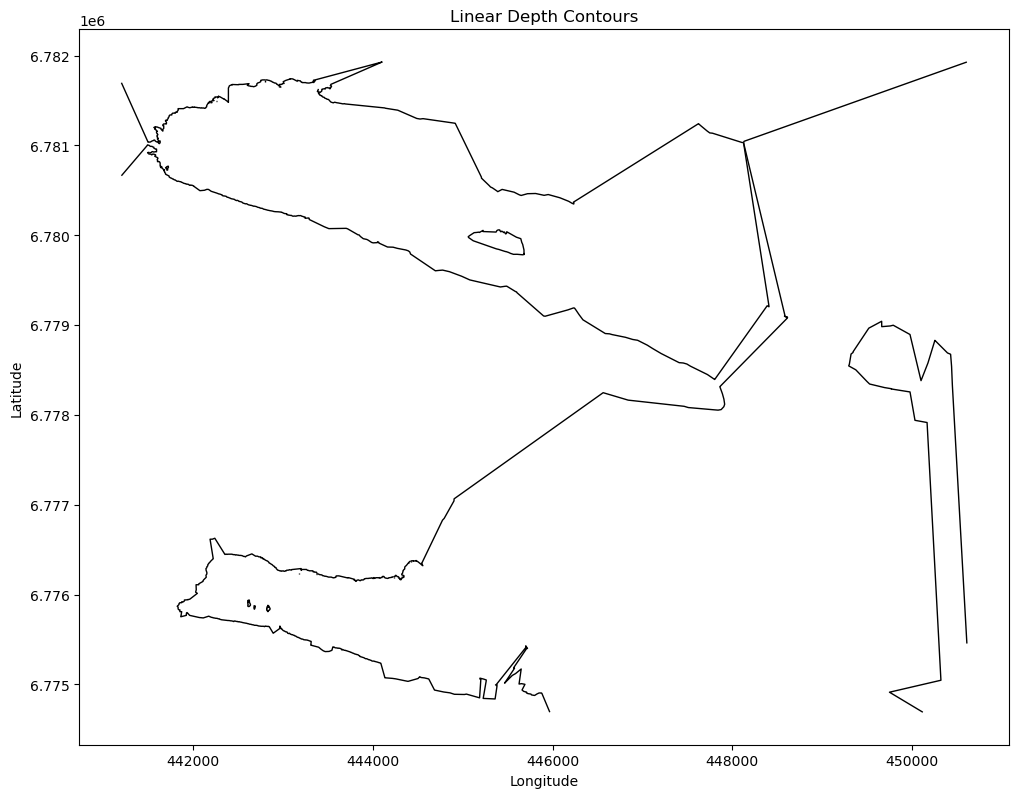

Visualizing Linearly Interpolated Contour File completed in 0.070993 seconds


In [34]:
# This cell performs the following tasks:
#     Read triangulation
#     Contour triangulated surface via linear interpolation
#     Visualize contours

import geopandas as gpd
import datetime
import BitVector
import json
import matplotlib.pyplot as plt
from math import ceil
from collections import defaultdict
from shapely.ops import unary_union, linemerge
from shapely.geometry import Point
from shapely import STRtree

# Triangulation tools in utilities
import sys
sys.path.insert(1, r'./lib')
from utilities import *
from reader import Reader
from tree import Tree
# --------------------------- Configuration --------------------------- #

# Parametrs
input_layer_path = r'./output/Bathymetric_Features/source_soundings_final.gpkg'
bathymetric_extent_path = r'./output/Bathymetric_Features/Bathymetric_Extent.geojson'
shoreline_path = './output/Land_Features/shoreline_clip_with_chartlimit_utm.geojson'
linear_contours_output_path = r'./output/Bathymetric_Features/Linear_Depth_Contours.gpkg'

# Depth direction, positive or negative down. This allows us to filter out intertidal and land soundings.
# This needs to be an input parameter from the user.
depth_direction = 'NEGATIVE_DOWN' # or POSITIVE_DOWN

# Define the JSON file path
PARAMS_FILE = "./input/user_parameters.json"

def load_parameters():
    """Loads parameters from the JSON file."""
    if os.path.exists(PARAMS_FILE):
        with open(PARAMS_FILE, "r") as f:
            return json.load(f)
    return {}

# Retrieve user-defined parameters
params = load_parameters()
contour_list = params['contour_list']

# Read bathymetric extent
# This extent is used to constrain the triangulation to the "water" area and to eliminate polygons over land
# when depth area polygons are being created. 
# Start timing
start_time = datetime.datetime.now()
print(f"Reading Bathymetric Extent File: {start_time}")

projected_bathymetric_extent_gdf = gpd.read_file(bathymetric_extent_path)
projected_bathymetric_extent = unary_union(projected_bathymetric_extent_gdf.geometry)

# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Reading Bathymetric Extent File completed in {elapsed_time.total_seconds()} seconds")

# Get coordinate system information to remain in projected coordinate system (meters)
projected_coord_system = projected_bathymetric_extent_gdf.crs

# Read input soundings
# Reads the input soundings, which were derived in a previous step (source_soundings_clipped.gpkg), where
# the source soundings are clipped to the chart extent
# Start timing
start_time = datetime.datetime.now()
print(f"Reading Filtered Soundings File: {start_time}")

# Read source data
projected_source_soundings_gdf = gpd.read_file(input_layer_path)
depth_field = r'SOUNDG'
projected_source_soundings = [[point.x, point.y, depth] for point, depth in zip(projected_source_soundings_gdf.geometry, projected_source_soundings_gdf[depth_field])]

# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Filtered Sounding Count: {len(projected_source_all_data_frame.geometry)}")
print(f"Reading Filtered Soundings File completed in {elapsed_time.total_seconds()} seconds")

# Read shore line
# Shoreline is used to attibute corresponding vertices of the bathymetric extent with a depth of 0
# Start timing
start_time = datetime.datetime.now()
print(f"Reading Shoreline File: {start_time}")

projected_shoreline_gdf = gpd.read_file(shoreline_path)
projected_shoreline_clip_gdf = gpd.clip(projected_shoreline_gdf, projected_bathymetric_extent_gdf)
projected_shoreline = projected_shoreline_clip_gdf.geometry
shoreline_merged = linemerge(unary_union(projected_shoreline))

# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Reading Shoreline completed in {elapsed_time.total_seconds()} seconds")

# Read TIN into data structure
# The triangulation does not store vertex z values, so it is read into a PR-Region quadtree where vertex objects 
# storing the x,y,z information are endcoded. The quadtree data structure is then used for efficient contouring.
# Start timing
start_time = datetime.datetime.now()
print(f"Reading TIN: {start_time}")

# Read dictionary from file
with open(tin_dict_path, 'r') as file: 
    triangulation_dict = json.loads(file.read())

# Read TIN into quadtree
print(f"[INFO] Number of soundings: {len(projected_source_soundings_pointset.get_all_vertices())}")
print(f"[INFO] Number of boundary segment vertices: {len(segments)}")

projected_source_soundings_and_boundary = projected_source_soundings_pointset.get_all_vertices() + segments
print(f"[INFO] Total vertices for triangulation: {len(projected_source_soundings_and_boundary)}")

projected_source_soundings_and_boundary_tin = Reader.read_triangulation(triangulation_dict, projected_source_soundings_and_boundary)
print(f"[INFO] Number of triangles in TIN: {projected_source_soundings_and_boundary_tin.get_triangles_num()}")
print(f"[INFO] Number of vertices in TIN: {projected_source_soundings_and_boundary_tin.get_vertices_num()}")

capacity = int(ceil(len(projected_source_soundings) * 0.004))
print(f"[INFO] Quadtree node capacity set to: {capacity}")

projected_source_soundings_and_boundary_tree = Tree(capacity)
projected_source_soundings_and_boundary_tree.build_tin_tree(projected_source_soundings_and_boundary_tin)
print("[INFO] TIN tree built successfully")

# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"[TIMER] Reading TIN completed in {elapsed_time.total_seconds()} seconds")

# Set the minimum and maximum depth values for each leaf node of the quadtree
start_time = datetime.datetime.now()
print(f"[TIMER] Contouring TIN started at: {start_time}")

projected_source_soundings_and_boundary_tree.set_min_max(
    projected_source_soundings_and_boundary_tree.get_root(), 0, projected_source_soundings_and_boundary_tin
)

print("[INFO] Quadtree min/max depth values set")
points, bit_vector = list(), dict()

# Contouring
# List of contours, update this to make it a parameter. Append a value to this list, which is later used during depth area
# generation. This value is the final depth limit for the deepest depth area. This list is used again in depth area creation,
# be sure to update both when one is edited
#contour_list = [0, 2, 5, 10, 20, 30, 50, 100]
if depth_direction == 'NEGATIVE_DOWN':
    contour_list = [-i for i in contour_list]
elif depth_direction == 'POSITIVE_DOWN':
    contour_list = contour_list
else:
    print('Provide NEGATIVE_DOWN or POSITIVE_DOWN for depth values.')
    sys.exit()
    
contour_list.append(contour_list[-1] + contour_list[-1])

# A bit vector is used to mark already visited triangles, which further increases efficiency
for z in contour_list:
    bit_vector[z] = BitVector.BitVector(size=projected_source_soundings_and_boundary_tin.get_triangles_num())

# Perform contouring via linear interpolation on the quadtree data structure.
projected_source_soundings_and_boundary_tree.contour(projected_source_soundings_and_boundary_tree.get_root(), 0, projected_source_soundings_and_boundary_tin, contour_list, points, bit_vector)
      
# Contours are returned as a list of points that represent segments of the contour
edges = [(points[i]) for i in range(len(points))]
edges_by_z = defaultdict(list)
for edge in edges:
    edge_start, edge_end = edge[0], edge[1]
    contour_segment = LineString([(edge_start[0], edge_start[1]), (edge_end[0], edge_end[1])]).difference(projected_bathymetric_extent.boundary)
    contour_z = abs(edge_start[2])

    if contour_segment:
        edges_by_z[contour_z].append(contour_segment)

# Merge line segments for each z-value
unioned_edges_by_z = dict()
for z, segments in edges_by_z.items():
    merged_segments = linemerge(unary_union(segments))
    unioned_edges_by_z[z] = merged_segments

# Store linearly interpolated contours in a geodataframe
contours_dissolved_gdf = gpd.GeoDataFrame({'VALDCO': list(unioned_edges_by_z.keys()), 'geometry': list(unioned_edges_by_z.values())}, crs=projected_coord_system)

# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Contouring completed in {elapsed_time.total_seconds()} seconds")

# Write contour file
# Start timing
start_time = datetime.datetime.now()
print(f"Writing Linearly Interpolated Contour File: {start_time}")

if os.path.exists(linear_contours_output_path):
    os.remove(linear_contours_output_path)
contours_dissolved_gdf.to_file(linear_contours_output_path, driver="GPKG")

# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Writing Linearly Interpolated Contour File completed in {elapsed_time.total_seconds()} seconds")

# Visualize Depth Contours
# Start timing
start_time = datetime.datetime.now()
print(f"Visualizing Linearly Interpolated Contour File: {start_time}")

# Visualization
fig, ax = plt.subplots(figsize=(12, 10))
contours_dissolved_gdf.plot(ax=ax, edgecolor='black', linewidth=1)

# Add plot details
plt.title('Linear Depth Contours')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Visualizing Linearly Interpolated Contour File completed in {elapsed_time.total_seconds()} seconds")

Reading Linear Contours File: 2025-04-17 09:27:58.554756
Reading Linear Contours File completed in 0.0169 seconds
Reading Bathymetric Extent File: 2025-04-17 09:27:58.571743
Reading Bathymetric Extent File completed in 0.010218 seconds
Smoothing Depth Contours: 2025-04-17 09:27:58.582056
Smoothing Iteration count: 5
Smoothing Depth Contours completed in 0.050191 seconds
Writing Smoothed Contour File: 2025-04-17 09:27:58.632321
Writing Smoothed Contour File completed in 0.037487 seconds
Visualizing Final Contour File: 2025-04-17 09:27:58.669886


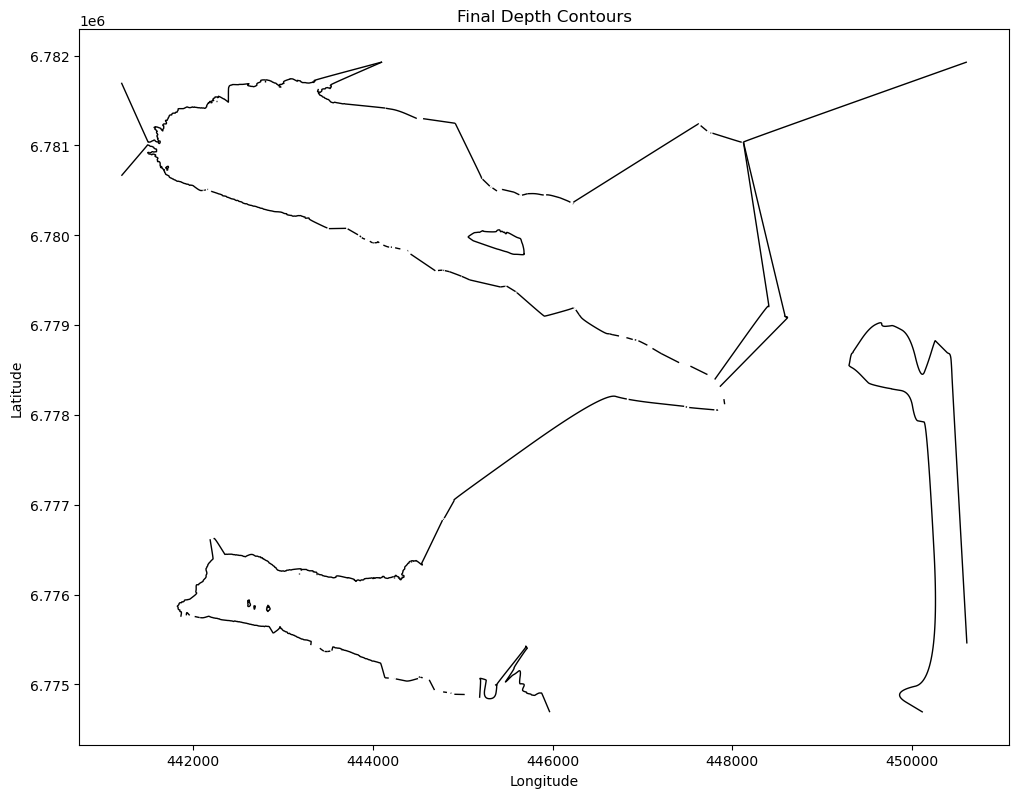

Visualizing Final Contour File completed in 0.088718 seconds


In [35]:
# This cell performs the following tasks:
#     Read linearly interpolated contours
#     Smooth contours
#     Visualize contours

import geopandas
import datetime
import matplotlib.pyplot as plt
from shapelysmooth import chaikin_smooth
from shapely.geometry import MultiLineString
from shapely import STRtree, snap
# --------------------------- Configuration --------------------------- #

# Parametrs
linear_contours_path = r'./output/Bathymetric_Features/Linear_Depth_Contours.gpkg'
contours_output_path = r'./output/Bathymetric_Features/Depth_Contours.gpkg'
bathymetric_extent_path = r'./output/Bathymetric_Features/Bathymetric_Extent.geojson'

# Read linear contours
# Start timing
start_time = datetime.datetime.now()
print(f"Reading Linear Contours File: {start_time}")

contours_dissolved_gdf = geopandas.read_file(linear_contours_path)
projected_coord_system = contours_dissolved_gdf.crs

# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Reading Linear Contours File completed in {elapsed_time.total_seconds()} seconds")

# Read bathymetric extent
# Start timing
start_time = datetime.datetime.now()
print(f"Reading Bathymetric Extent File: {start_time}")

projected_bathymetric_extent_gdf = geopandas.read_file(bathymetric_extent_path)

# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Reading Bathymetric Extent File completed in {elapsed_time.total_seconds()} seconds")

# Smooth contours
# Smooth the linearly interpolated depth contours using the shapelysmooth package (chaikin interpolation). This algorithm was used because 
# the package allows you to explicitly preserve endpoints when smoothing, which is critical for creating depth areas. The contours must be
# snapped to the bathymetric extent for depth area generation. Another algorithm may be used as long as it preserves endpoints.
# Start timing
start_time = datetime.datetime.now()
print(f"Smoothing Depth Contours: {start_time}")

# The smoothing approach starts with a given number of iterations (smooth_iterations = 3) and smooths the linearly interpolated contours.
# The smoothed contours are then assessed for crosses, which prevent subsequent depth area generation. If crosses are detected, the number
# of iterations is reduced by one and the process is repeated. This is performed iteratively until no crossing contours are found, which 
# can result in no smoothing (linear interpolation) for the final depth contours in certain circumstances.
smooth_iterations = 5
while smooth_iterations > 0:
    print(f'Smoothing Iteration count: {smooth_iterations}')
    keep_endpoints = True
    smoothed_contour_geoms, smoothed_contour_z_vals = list(), list()
    for index, row in contours_dissolved_gdf.iterrows():
        # Smooth contours
        smoothed_contour_geom = MultiLineString([chaikin_smooth(part, smooth_iterations, keep_endpoints) for part in row['geometry'].geoms])
        smoothed_contour_depth = row['VALDCO']
        smoothed_contour_geoms.append(smoothed_contour_geom)
        smoothed_contour_z_vals.append({'VALDCO': smoothed_contour_depth})

    # Clip smooth contours to bathmetric extent; smoothing can move contours on land
    smoothed_contours_gdf = geopandas.GeoDataFrame(smoothed_contour_z_vals, geometry=smoothed_contour_geoms, crs=projected_coord_system)
    smooth_contours_clip_gdf = geopandas.clip(smoothed_contours_gdf, projected_bathymetric_extent_gdf)
    
    # Check for intersections
    tree = STRtree(smooth_contours_clip_gdf.geometry)
    intersections = False
    for geom in smooth_contours_clip_gdf.geometry:
        potential_matches_idx = tree.query(geom, 'intersects')
        potential_matches_geoms = tree.geometries.take(potential_matches_idx).tolist()
        potential_matches_geoms_not_self = [match for match in potential_matches_geoms if match != geom]
        for potential_match in potential_matches_geoms_not_self:
            if potential_match.intersects(geom):
                intersections = True
                break
        if intersections:
            break

    if intersections:
        smooth_iterations -= 1
    else: 
        break
    
# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Smoothing Depth Contours completed in {elapsed_time.total_seconds()} seconds")

# Write contour file
# Start timing
start_time = datetime.datetime.now()
print(f"Writing Smoothed Contour File: {start_time}")

if os.path.exists(contours_output_path):
    os.remove(contours_output_path)

if smooth_iterations == 0:
    print(f"Contours are Linearly Interpolated Due to Contour Crossing Resulting from Smoothing")
    contours_dissolved_single_part_gdf = contours_dissolved_gdf.explode(index_parts=False)
    # contours_dissolved_single_part_gdf.to_file(contours_output_path, driver="GPKG") # linear interpolation
    contours_dissolved_gdf.to_file(contours_output_path, driver="GPKG")
else:
    smooth_contours_clip_gdf.to_file(contours_output_path, driver="GPKG")

# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Writing Smoothed Contour File completed in {elapsed_time.total_seconds()} seconds")

# Visualize Depth Contours
# Start timing
start_time = datetime.datetime.now()
print(f"Visualizing Final Contour File: {start_time}")

# Visualization
fig, ax = plt.subplots(figsize=(12, 10))
smooth_contours_clip_gdf.plot(ax=ax, edgecolor='black', linewidth=1)

# Add plot details
plt.title('Final Depth Contours')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Visualizing Final Contour File completed in {elapsed_time.total_seconds()} seconds")

Reading Final Contours File: 2025-04-17 09:56:41.348145
Reading Final Contours File completed in 0.072619 seconds
Reading Bathymetric Extent File: 2025-04-17 09:56:41.421394
Reading Bathymetric Extent File completed in 0.034885 seconds
Reading Land Points File: 2025-04-17 09:56:41.456354
Reading Land Points File completed in 0.007687 seconds
Generating Depth Areas: 2025-04-17 09:56:41.464116
contour_list:[0, 10, 20, 30, 50, 100]
Generating Depth Areas completed in 0.54064 seconds
Writing Depth Area File: 2025-04-17 09:56:42.004882
Writing Depth Area File completed in 0.262758 seconds
Visualizing Depth Area File: 2025-04-17 09:56:42.267764


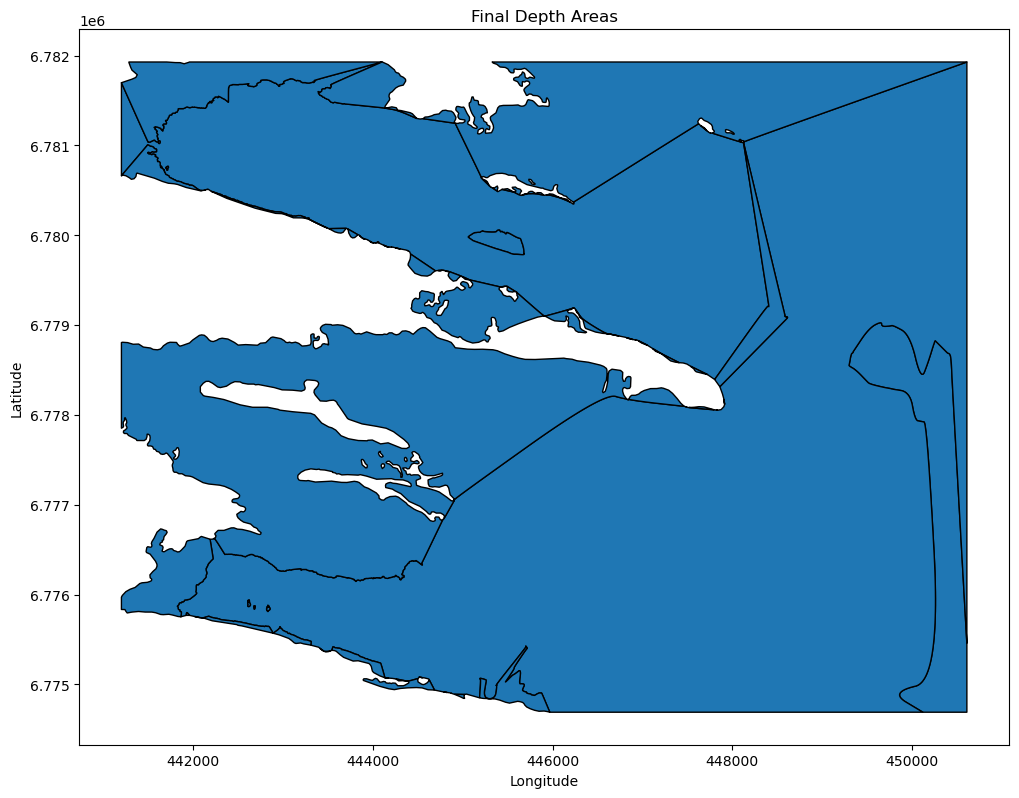

Visualizing Final Depth Area completed in 0.112596 seconds


In [38]:
# This cell performs the following tasks:
#     Generate Depth Areas
#     Attribute Depth Areas
#     Visualize Depth Areas

import geopandas
import datetime
import matplotlib.pyplot as plt
from shapely import get_parts
from shapely.ops import unary_union, polygonize, split
# --------------------------- Configuration --------------------------- #

# Parameters
bathymetric_extent_path = r'./output/Bathymetric_Features/Bathymetric_Extent.geojson'
final_contour_path = r'./output/Bathymetric_Features/Depth_Contours.gpkg'
land_points_path = './output/Land_Features/land_points.gpkg'
depth_areas_output_path = r'./output/Bathymetric_Features/Depth_Areas.gpkg'
depth_areas_geojson = r'./output/Bathymetric_Features/Depth_Areas_wgs84.geojson'

# Read final contours
# Start timing
start_time = datetime.datetime.now()
print(f"Reading Final Contours File: {start_time}")

smooth_contours_clip_single_part_gdf = geopandas.read_file(final_contour_path)

# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Reading Final Contours File completed in {elapsed_time.total_seconds()} seconds")

# Read bathymetric extent
# Start timing
start_time = datetime.datetime.now()
print(f"Reading Bathymetric Extent File: {start_time}")

projected_bathymetric_extent_gdf = geopandas.read_file(bathymetric_extent_path)
projected_bathymetric_extent = unary_union(projected_bathymetric_extent_gdf.geometry)

# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Reading Bathymetric Extent File completed in {elapsed_time.total_seconds()} seconds")

# Read land points
# Start timing
start_time = datetime.datetime.now()
print(f"Reading Land Points File: {start_time}")

land_points_gdf = geopandas.read_file(land_points_path)

# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Reading Land Points File completed in {elapsed_time.total_seconds()} seconds")

# Generate Depth Areas
# Generate depth areas by polygonizing the combined bathymetric extent and depth contours.
# Start timing
start_time = datetime.datetime.now()
print(f"Generating Depth Areas: {start_time}")

# Contour list from previous cell. Be sure both lists are consistent, always positive because we convert earlier
#contour_list = [0, 2, 5, 10, 20, 30, 50, 100, 200]
# Define the JSON file path
PARAMS_FILE = "./input/user_parameters.json"

def load_parameters():
    """Loads parameters from the JSON file."""
    if os.path.exists(PARAMS_FILE):
        with open(PARAMS_FILE, "r") as f:
            return json.load(f)
    return {}

# Retrieve user-defined parameters
params = load_parameters()
contour_list = params['contour_list']
print(f'contour_list:{contour_list}')
contour_list.append(contour_list[-1] + contour_list[-1])
contour_list.append(contour_list[-1] + contour_list[-1])

# Combine bathymetric extent and depth contours
final_contours_geoms = list(smooth_contours_clip_single_part_gdf.geometry)
final_contours_geoms.append(projected_bathymetric_extent.boundary)

depth_areas = get_parts(polygonize(unary_union(final_contours_geoms)))
depth_areas_geoms_final = [depth_area for depth_area in depth_areas if not any(depth_area.intersects(land_point) for land_point in land_points_gdf.geometry)]

# Update the depth limit attributes of the depth areas using the depth contours
depth_limit_shallow, depth_limit_deep = list(), list()
for depth_area in depth_areas_geoms_final:
    depth_ranges = list()
    for idx, row in smooth_contours_clip_single_part_gdf.iterrows():
        contour_geom = row['geometry']
        contour_depth = row['VALDCO']
        if depth_area.intersects(contour_geom):
            depth_ranges.append(contour_depth)
    if len(depth_ranges) > 1:
        if len(depth_ranges) > 2:
            minimum = min(depth_ranges)
            depth_ranges.remove(minimum)
        depth_limit_shallow.append(min(depth_ranges))
        depth_limit_deep.append(max(depth_ranges))
    elif len(depth_ranges) == 1:
        if depth_ranges[0] == 0:
            depth_limit_shallow.append(0)
            depth_limit_deep.append(0)        
        else:
            contour_idx = contour_list.index(depth_ranges[0])
            depth_limit_shallow.append(depth_ranges[0])
            depth_limit_deep.append(contour_list[contour_idx+1])
    else:
        depth_limit_shallow.append('NULL')
        depth_limit_deep.append('NULL')

# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Generating Depth Areas completed in {elapsed_time.total_seconds()} seconds")

# Write depth area file
# Start timing
start_time = datetime.datetime.now()
print(f"Writing Depth Area File: {start_time}")

depth_areas_gdf = geopandas.GeoDataFrame({"geometry": depth_areas_geoms_final, 'DRVAL1': depth_limit_shallow, 'DRVAL2': depth_limit_deep}, crs=projected_coord_system)

# Exclude rows where DRVAL1 or DRVAL2 are 'NULL' (as strings)
depth_areas_gdf = depth_areas_gdf[
    (depth_areas_gdf['DRVAL1'] != 'NULL') & (depth_areas_gdf['DRVAL2'] != 'NULL')
]

if os.path.exists(depth_areas_output_path):
    os.remove(depth_areas_output_path)
depth_areas_gdf.to_file(depth_areas_output_path, driver="GPKG")

depth_areas_gdf.to_crs(epsg=4326).to_file(depth_areas_geojson, driver="GeoJSON")  

# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Writing Depth Area File completed in {elapsed_time.total_seconds()} seconds")

# Visualize Depth Areas
# Start timing
start_time = datetime.datetime.now()
print(f"Visualizing Depth Area File: {start_time}")

# Visualization
fig, ax = plt.subplots(figsize=(12, 10))
depth_areas_gdf.plot(ax=ax, edgecolor='black', linewidth=1)

# Add plot details
plt.title('Final Depth Areas')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# End timing
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Visualizing Final Depth Area completed in {elapsed_time.total_seconds()} seconds")